In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
county = pd.read_csv("MMG_county_df_clean.csv")
county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31419 entries, 0 to 31418
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          31419 non-null  int64  
 1   FIPS                          31419 non-null  float64
 2   County                        31419 non-null  object 
 3   State                         31419 non-null  object 
 4   Food_Insecurity_Rate          31419 non-null  float64
 5   Num_Food_Insecure_Persons     31419 non-null  float64
 6   Low_Threshold_State           31419 non-null  float64
 7   Low_Threshold_Type            31419 non-null  object 
 8   High_Threshold_State          31419 non-null  float64
 9   High_Threshold_Type           31419 non-null  object 
 10  Pct_FI_Below_Low_Threshold    31419 non-null  float64
 11  Pct_FI_Between_Thresholds     26628 non-null  float64
 12  Pct_FI_Above_High_Threshold   31419 non-null  float64
 13  C

In [ ]:
county.head(10)


,Year,FIPS,County,State,Food_Insecurity_Rate,Num_Food_Insecure_Persons,Low_Threshold_State,Low_Threshold_Type,High_Threshold_State,High_Threshold_Type,Pct_FI_Below_Low_Threshold,Pct_FI_Between_Thresholds,Pct_FI_Above_High_Threshold,Child_Food_Insecurity_Rate,Num_Food_Insecure_Children,Pct_FI_Children_Below_185FPL,Pct_FI_Children_Above_185FPL,Cost_Per_Meal,Annual_Food_Budget_Shortfall
0,2018,1001.0,autauga,AL,0.156,8620.0,1.3,SNAP,1.85,Other Nutrition Program,0.462,0.132,0.405,0.214,2870.0,0.69,0.31,3.33,4857000.0
1,2018,1003.0,baldwin,AL,0.129,26860.0,1.3,SNAP,1.85,Other Nutrition Program,0.371,0.187,0.442,0.169,7710.0,0.74,0.27,3.58,16274000.0
2,2018,1005.0,barbour,AL,0.219,5650.0,1.3,SNAP,1.85,Other Nutrition Program,0.651,0.108,0.241,0.32,1740.0,0.76,0.25,3.12,2988000.0
3,2018,1007.0,bibb,AL,0.151,3400.0,1.3,SNAP,1.85,Other Nutrition Program,0.469,0.212,0.319,0.209,970.0,0.92,0.08,2.94,1690000.0
4,2018,1009.0,blount,AL,0.136,7810.0,1.3,SNAP,1.85,Other Nutrition Program,0.429,0.279,0.292,0.191,2580.0,0.94,0.06,3.14,4149000.0
5,2018,1011.0,bullock,AL,0.205,2120.0,1.3,SNAP,1.85,Other Nutrition Program,0.749,0.003,0.247,0.324,700.0,0.52,0.48,3.32,1192000.0
6,2018,1013.0,butler,AL,0.191,3820.0,1.3,SNAP,1.85,Other Nutrition Program,0.669,0.130,0.201,0.27,1230.0,0.8,0.2,2.97,1917000.0
7,2018,1015.0,calhoun,AL,0.174,20050.0,1.3,SNAP,1.85,Other Nutrition Program,0.553,0.195,0.252,0.246,6210.0,0.87,0.13,2.98,10097000.0
8,2018,1017.0,chambers,AL,0.164,5530.0,1.3,SNAP,1.85,Other Nutrition Program,0.603,0.227,0.170,0.222,1560.0,0.86,0.14,2.92,2730000.0
9,2018,1019.0,cherokee,AL,0.156,4040.0,1.3,SNAP,1.85,Other Nutrition Program,0.487,0.311,0.202,0.211,1110.0,0.94,0.06,3.25,2221000.0


In [ ]:
county["Food_Insecurity_Rate"].describe()

count    31419.000000
mean         0.145205
std          0.041776
min          0.024000
25%          0.117000
50%          0.141000
75%          0.168000
max          0.379000
Name: Food_Insecurity_Rate, dtype: float64

In [ ]:
bins = [0, 0.117, 0.141, 0.168, 1]  # 1 is just a safe upper bound
labels = ["Low", "Moderate", "Elevated", "High"]

county["FI_Category"] = pd.cut(
    county["Food_Insecurity_Rate"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

county["FI_Category"].value_counts()

FI_Category
Low         8003
Moderate    7843
High        7801
Elevated    7772
Name: count, dtype: int64

### Step 1: Dropping Non-Predictive Columns

In [ ]:
drop_cols = [
    "FIPS",
    "County",
    "State",
    "Food_Insecurity_Rate",
    "Num_Food_Insecure_Persons",
    "Child_Food_Insecurity_Rate",
    "Num_Food_Insecure_Children",
    "FI_Category"  # target
]

### Step 2: Defining X & Y

In [ ]:
X = county.drop(columns=drop_cols, errors='ignore')
y = county["FI_Category"]

### Step 3: One-Hot Encoding Categorical Columns

In [ ]:
X = pd.get_dummies(X, drop_first=True)

### Step 4: Parsing Missing Values

In [ ]:
county.isna().sum()

Year                               0
FIPS                               0
County                             0
State                              0
Food_Insecurity_Rate               0
Num_Food_Insecure_Persons          0
Low_Threshold_State                0
Low_Threshold_Type                 0
High_Threshold_State               0
High_Threshold_Type                0
Pct_FI_Below_Low_Threshold         0
Pct_FI_Between_Thresholds       4791
Pct_FI_Above_High_Threshold        0
Child_Food_Insecurity_Rate         5
Num_Food_Insecure_Children         5
Pct_FI_Children_Below_185FPL       0
Pct_FI_Children_Above_185FPL       0
Cost_Per_Meal                     28
Annual_Food_Budget_Shortfall      28
FI_Category                        0
dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

### Step 5: Scaling Predictor Columns

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

### Step 6: Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### Step 7: Pipeline

In [ ]:
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

### Step 8: Using GridSearchCV to Tune K

In [ ]:
param_grid = {
    "knn__n_neighbors": [5, 9, 15],
    "knn__weights": ["uniform", "distance"],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Best params: {'knn__n_neighbors': 15, 'knn__weights': 'distance'}
Best CV accuracy: 0.40131284191183286


### Step 9: Refitting Best Model on the Full Training Data

In [ ]:
best_params = grid.best_params_

pipe.set_params(**best_params)
pipe.fit(X_train, y_train)

,steps,"[('scaler', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,15
,weights,'distance'
,algorithm,'auto'
,leaf_size,30


### Step 10: Evaluating Model Performance on Test Data

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = pipe.predict(X_test)

test_acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_acc)

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

Test accuracy: 0.4156588160407384

Classification report:
              precision    recall  f1-score   support

    Elevated       0.34      0.35      0.35      1554
        High       0.45      0.47      0.46      1560
         Low       0.50      0.54      0.52      1601
    Moderate       0.35      0.31      0.32      1569

    accuracy                           0.42      6284
   macro avg       0.41      0.41      0.41      6284
weighted avg       0.41      0.42      0.41      6284


Confusion matrix:
[[538 427 257 332]
 [428 735 158 239]
 [218 185 858 340]
 [378 277 433 481]]


### Step 11: Comparing to a Baseline Model

In [ ]:
majority_class = y_train.value_counts().idxmax()
baseline_pred = np.full_like(y_test, fill_value=majority_class)

baseline_acc = accuracy_score(y_test, baseline_pred)
print("Baseline (majority class) accuracy:", baseline_acc)
print("Lift over baseline:", test_acc - baseline_acc)

Baseline (majority class) accuracy: 0.2547740292807129
Lift over baseline: 0.1608847867600255


### Step 12: Decision Regions in 2D

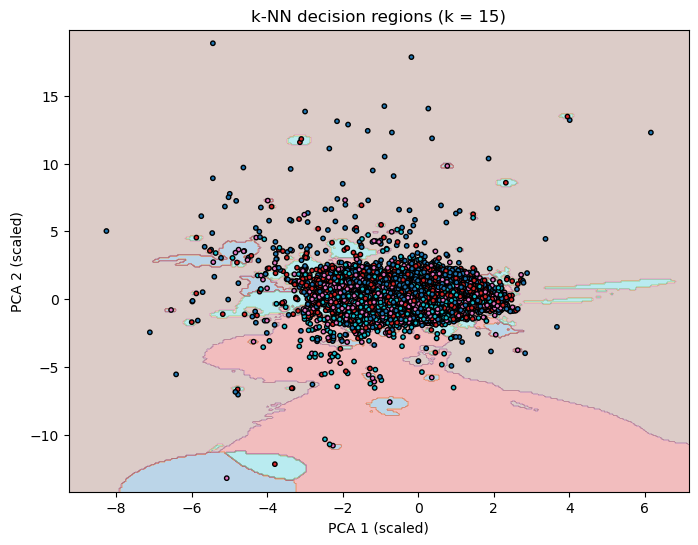

In [ ]:
# 4. Plot decision regions + training points

# Z is currently category strings from knn_2d.predict(...)
# Convert them to integer codes for contourf
le = LabelEncoder()
Z_num = le.fit_transform(Z.ravel()).reshape(Z.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_num, alpha=0.3, cmap="tab10")

# scatter training points, colored by FI category codes
y_codes = y_train.astype("category").cat.codes.to_numpy()

plt.scatter(
    X_train_2d_scaled[:, 0],
    X_train_2d_scaled[:, 1],
    c=y_codes,
    cmap="tab10",
    edgecolor="k",
    s=10,
)

plt.xlabel("PCA 1 (scaled)")
plt.ylabel("PCA 2 (scaled)")
plt.title("k-NN decision regions (k = 15)")
plt.show()

### Step 13: Visualizing Neighbors of a Single County

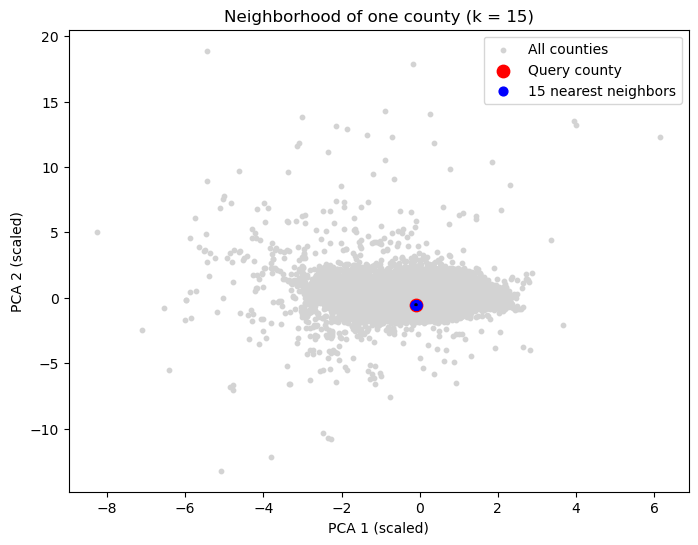

In [ ]:
# picking an arbitrary index from the training set to inspect
idx = 3000  # for example

distances, indices = knn_2d.kneighbors(
    X_train_2d_scaled[idx].reshape(1, -1),
    n_neighbors=15
)

neighbors_idx = indices[0]

plt.figure(figsize=(8, 6))

# all points
plt.scatter(
    X_train_2d_scaled[:, 0],
    X_train_2d_scaled[:, 1],
    c="lightgray",
    s=10,
    label="All counties"
)

# query point
plt.scatter(
    X_train_2d_scaled[idx, 0],
    X_train_2d_scaled[idx, 1],
    c="red",
    s=80,
    label="Query county"
)

# neighbors
plt.scatter(
    X_train_2d_scaled[neighbors_idx, 0],
    X_train_2d_scaled[neighbors_idx, 1],
    c="blue",
    s=40,
    label="15 nearest neighbors"
)

# draw lines from query point to neighbors
for j in neighbors_idx:
    plt.plot(
        [X_train_2d_scaled[idx, 0], X_train_2d_scaled[j, 0]],
        [X_train_2d_scaled[idx, 1], X_train_2d_scaled[j, 1]],
        "k-", alpha=0.3
    )

plt.legend()
plt.xlabel("PCA 1 (scaled)")
plt.ylabel("PCA 2 (scaled)")
plt.title("Neighborhood of one county (k = 15)")
plt.show()

In [ ]:
idx = 54  # any row index

row = X.iloc[idx:idx+1]       # keep as dataframe
pred = pipe.predict(row)[0]

print("Predicted FI Category:", pred)

Predicted FI Category: Elevated


/Users/mta/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
# Get prediction probabilities
probs = pipe.predict_proba(row)[0]
classes = pipe.named_steps["knn"].classes_

# Format into a clean dictionary
probs_dict = {cls: float(p) for cls, p in zip(classes, probs)}

print("Predicted FI Category:", pipe.predict(row)[0])
print("\nProbability Breakdown:")
for cls, p in probs_dict.items():
    print(f"  {cls:<10} -> {p:.3f}")

Predicted FI Category: Elevated

Probability Breakdown:
  Elevated   -> 0.400
  High       -> 0.333
  Low        -> 0.200
  Moderate   -> 0.067


/Users/mta/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/mta/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
